In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl

# mpl.rcParams['font.size'] = 13

In [3]:
base_path = r"C:\Users\jorge\Documents\GitHub\Telecontrol_r\PowerSmoothing"
resultados_path = os.path.join(base_path, 'ps_data')

In [6]:
FV = os.path.join(resultados_path, 'FV.txt')

with open(FV, 'r') as file:
    # Lee todas las líneas y las almacena en una lista
    lines = file.readlines()

# Convierte las líneas en valores flotantes y almacénalos en una lista
values = [float(line.strip()) for line in lines]
values

[-0.0999889,
 -0.0893506,
 -0.0787123,
 -0.068074,
 -0.0574357,
 -0.0467974,
 -0.0361591,
 -0.0255208,
 -0.0148825,
 -0.00424421,
 -0.00307185,
 -0.0132759,
 -0.02348,
 -0.0336841,
 -0.0438882,
 -0.0540923,
 -0.0642963,
 -0.0745004,
 -0.0847045,
 -0.0949086,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.0950441,
 -0.0851529,
 -0.0752617,
 -0.0653705,
 -0.0554793,
 -0.0455881,
 -0.0356969,
 -0.0258057,
 -0.0159145,
 -0.00602329,
 0.0,
 -0.00558002,
 -0.0169436,
 -0.0283073,
 -0.0396709,
 -0.0510346,
 -0.0623982,
 -0.0737618,
 -0.0851255,
 -0.0964891,
 -0.0959686,
 -0.0856593,
 -0.0753501,
 -0.0650408,
 -0.0547315,
 -0.0444222,
 -0.034113,
 -0.0238037,
 -0.0134944,
 -0.00318512,
 -0.00199005,
 -0.0124067,
 -0.0228234,
 -0.0332401,
 -0.0436567,
 -0.0540734,
 -0.06449,
 -0.0749067,
 -0.0853234,
 -0.0957401,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0.1,
 -0

<Axes: >

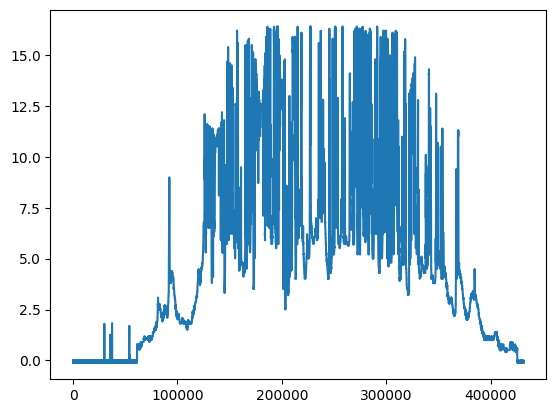

In [7]:
sns.lineplot(data=values)

<Axes: >

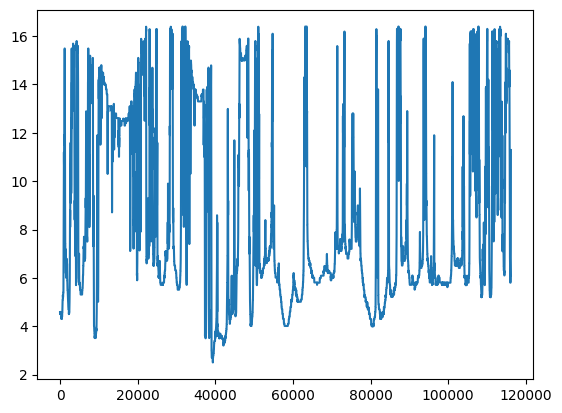

In [8]:
filtered_values = values[164078:280234]

# Plotea los valores filtrados
sns.lineplot(data=filtered_values)